<a href="https://colab.research.google.com/github/hajmamed/BigDataHws/blob/main/BigDataHW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pyspark --quiet
!pip install -U -q PyDrive --quiet 
!apt install openjdk-8-jdk-headless &> /dev/null

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pyspark
from pyspark.sql import SparkSession
filePath = '/content/drive/MyDrive/data.csv'

spark = SparkSession.builder.appName('BigDataHw4').getOrCreate()
sc=spark.sparkContext
df=spark.read.format("csv").option("header","true").load(filePath)
df.printSchema()
df.select("*").show(5)

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: string (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: string (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: string (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Label: string (nullable = true)

+----------+------+-------------+-------+----------+------+------------+-----------

In [4]:
df = df.withColumn("tenure",df.tenure.cast('double'))\
        .withColumn("MonthlyCharges",df.MonthlyCharges.cast('double'))\
        .withColumn("TotalCharges",df.TotalCharges.cast('double'))\
        .withColumn("SeniorCitizen",df.SeniorCitizen.cast('double'))
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: double (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: double (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: double (nullable = true)
 |-- Label: string (nullable = true)



# **Feature Engineering**

In [5]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|   225|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

In [6]:
for col in df.columns:
  if(col !="customerID" and col !="tenure" and col!="MonthlyCharges" and col!="TotalCharges"):
    distinct_cat=df.select(col).distinct().rdd.map(lambda r: r[0]).collect()
    print(col , "values: ", distinct_cat)

gender values:  [None, 'Female', 'Male']
SeniorCitizen values:  [0.0, None, 1.0, 14.0, 17.0]
Partner values:  [None, 'No', 'Yes']
Dependents values:  [None, 'No', 'Yes']
PhoneService values:  [None, 'No', 'Yes']
MultipleLines values:  ['No phone service', None, 'No', 'Yes']
InternetService values:  [None, 'Fiber optic', 'No', 'DSL']
OnlineSecurity values:  [None, 'No', 'Yes', 'No internet service']
OnlineBackup values:  [None, 'No', 'Yes', 'No internet service']
DeviceProtection values:  [None, 'No', 'Yes', 'No internet service']
TechSupport values:  [None, 'No', 'Yes', 'No internet service']
StreamingTV values:  [None, 'No', 'Yes', 'No internet service']
StreamingMovies values:  [None, 'No', 'Yes', 'No internet service']
Contract values:  ['Month-to-month', None, 'One year', 'Two year']
PaperlessBilling values:  [None, 'No', 'Yes']
PaymentMethod values:  ['Credit card (automatic)', None, 'Mailed check', 'Bank transfer (automatic)', 'Electronic check']
Label values:  [None, 'No', 'Yes'

# Columns Categorization 

Demographic Information
*   gender
*   SeniorCitizen
*   Partner
*   Dependents


Customer Account Information
*  tenure
* Contract
* PaperlessBilling
* PaymentMethod
* MontlyCharges
* TotalCharges

Services Information
* PhoneService
* MultipleLines
* InternetServices
* OnlineSecurity
* OnlineBackup
* DeviceProtection
* TechSupport
* StreamingTV
* StreamingMovies



In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import math

def percentage_stacked_plot(df_pd, columns_to_plot, super_title):
  number_of_columns = 2
  number_of_rows = math.ceil(len(columns_to_plot)/2)

  fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
  fig.suptitle(super_title, fontsize=22,  y=.95)
  
  for index, column in enumerate(columns_to_plot, 1):
      ax = fig.add_subplot(number_of_rows, number_of_columns, index)

      prop_by_independent = pd.crosstab(df_pd[column], df_pd['Label']).apply(lambda x: x/x.sum()*100, axis=1)
      prop_by_independent.plot(kind='bar', ax=ax, stacked=True,rot=0, color=['springgreen','salmon'])

      ax.legend(loc="upper right", bbox_to_anchor=(0.62, 0.5, 0.5, 0.5),title='Label', fancybox=True)
      ax.set_title(column + ' Ratio',fontsize=16, loc='left')
      ax.tick_params(rotation='auto')

      spine_names = ('top', 'right', 'bottom', 'left')
      for spine_name in spine_names:
          ax.spines[spine_name].set_visible(False)

def histogram_plots(df_pd, columns_to_plot, super_title):
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 
    for index, column in enumerate(columns_to_plot, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        df_pd[df_pd['Label']=='No'][column].plot(kind='hist', ax=ax, density=True, alpha=0.5, color='springgreen', label='No')
        df_pd[df_pd['Label']=='Yes'][column].plot(kind='hist', ax=ax, density=True, alpha=0.5, color='salmon', label='Yes')
        
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), title='Label', fancybox=True)
        ax.set_title(column + ' per Label', fontsize=16, loc='left')
        ax.tick_params(rotation='auto')

        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)


def density_plots(df_pd, columns_to_plot, super_title):
    number_of_columns = 2
    number_of_rows = math.ceil(len(columns_to_plot)/2)
    fig = plt.figure(figsize=(12, 5 * number_of_rows)) 
    fig.suptitle(super_title, fontsize=22,  y=.95)
 
    for index, column in enumerate(columns_to_plot, 1):
        ax = fig.add_subplot(number_of_rows, number_of_columns, index)
        df_pd[df_pd['Label']=='No'][column].plot(kind='density', ax=ax, alpha=0.5, color='springgreen', label='No')
        df_pd[df_pd['Label']=='Yes'][column].plot(kind='density', ax=ax, alpha=0.5, color='salmon', label='Yes')
        
        ax.legend(loc="upper right", bbox_to_anchor=(0.5, 0.5, 0.5, 0.5), title='Label', fancybox=True)
        ax.set_title(column + ' per Label', fontsize=16, loc='left')
        ax.tick_params(rotation='auto')

        spine_names = ('top', 'right', 'bottom', 'left')
        for spine_name in spine_names:
            ax.spines[spine_name].set_visible(False)
            

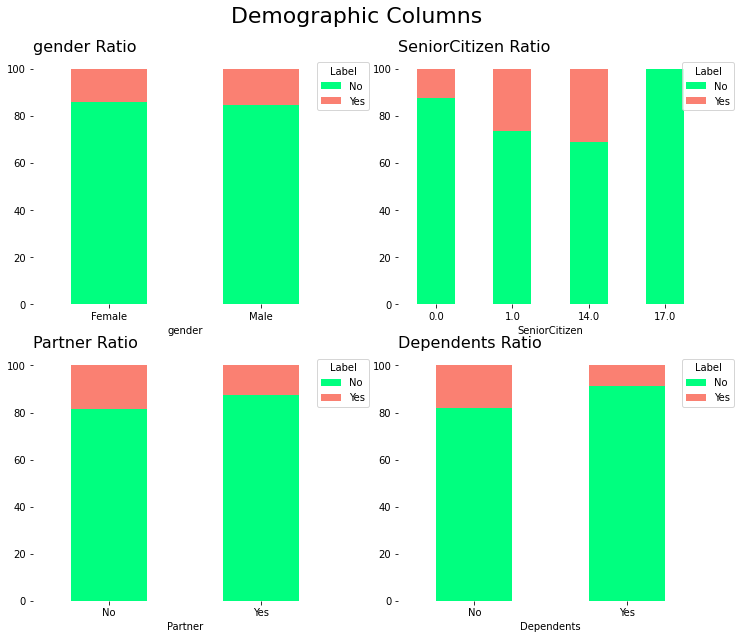

In [8]:
df_pd = df.toPandas()
demographiColumns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

percentage_stacked_plot(df_pd, demographiColumns, 'Demographic Columns')

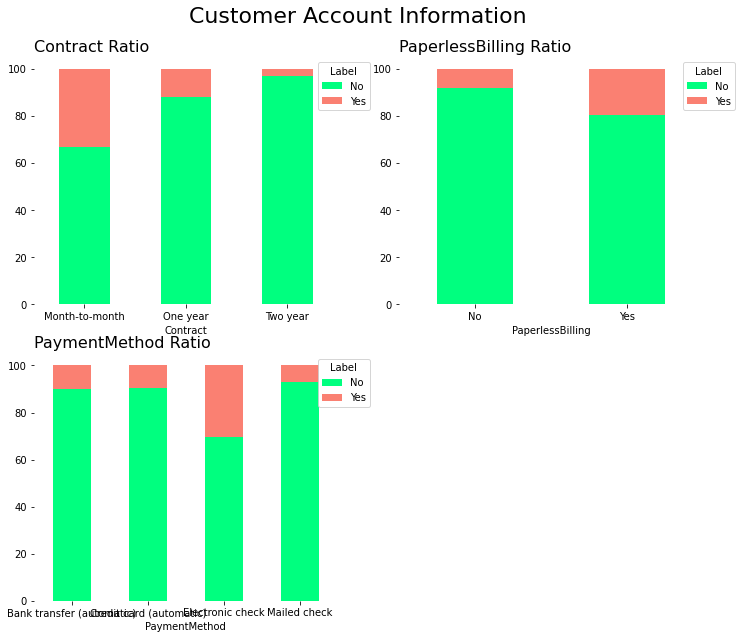

In [9]:
accountColumns = ['Contract', 'PaperlessBilling', 'PaymentMethod']
percentage_stacked_plot(df_pd, accountColumns, 'Customer Account Information')

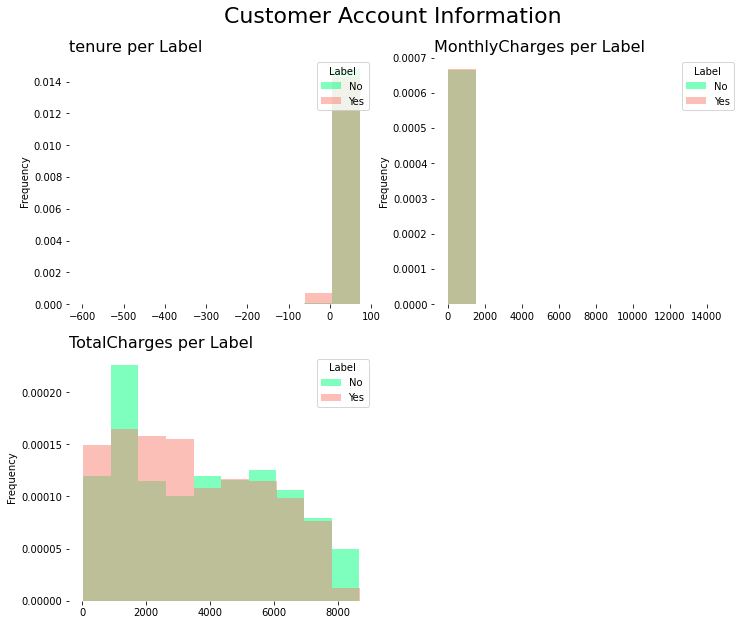

In [10]:
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
histogram_plots(df_pd, account_columns_numeric, 'Customer Account Information')

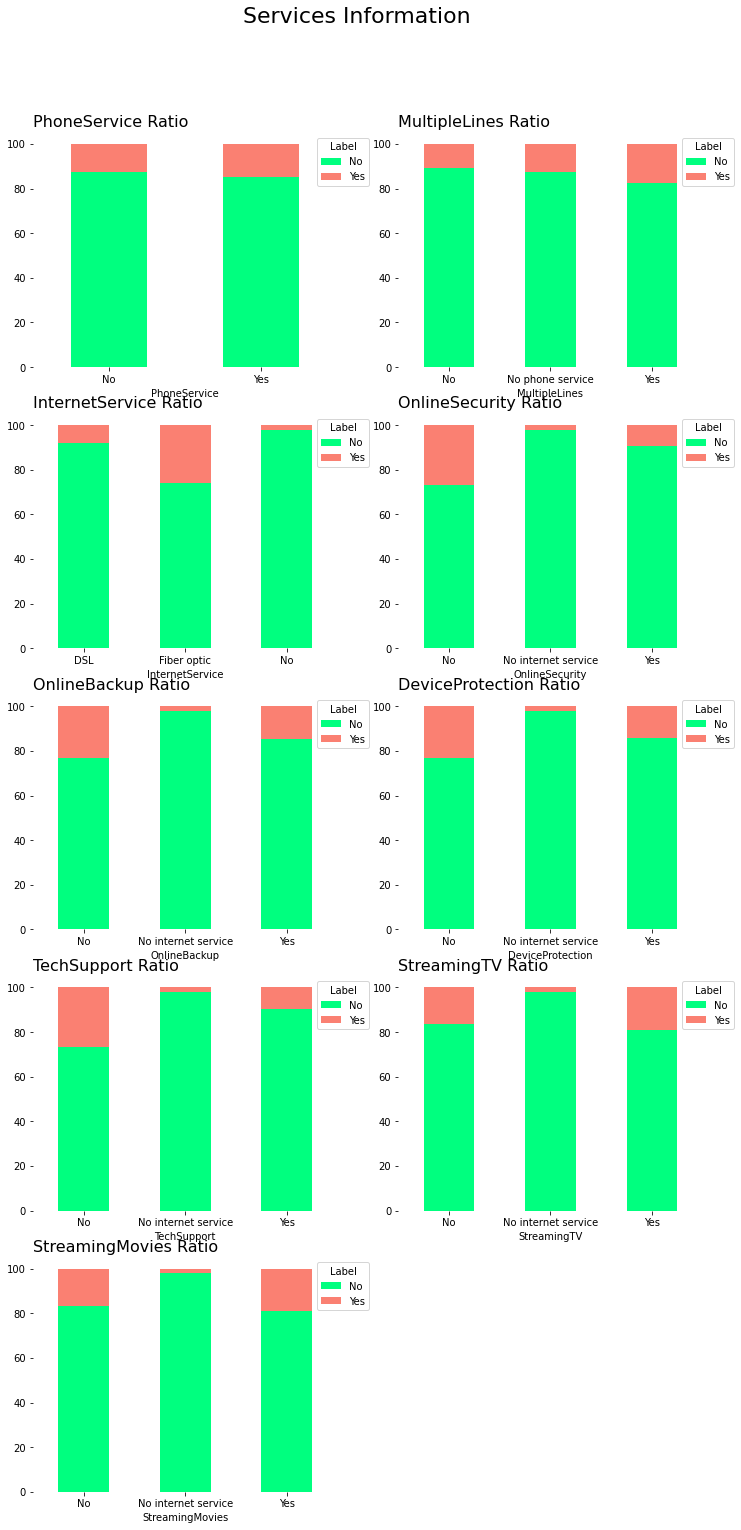

In [11]:
services_columns = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity','OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
percentage_stacked_plot(df_pd, services_columns, 'Services Information')

# Imputing

In [12]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col,isnan, when, count

imputer = Imputer(
    inputCols=['tenure','MonthlyCharges','TotalCharges'], 
    outputCols= ['tenure','MonthlyCharges','TotalCharges']
).setStrategy('mean')
df = imputer.fit(df).transform(df)

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|          266|    225|       242|     0|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

In [13]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql.functions import udf
import hashlib
from pyspark.sql.functions import col,isnan, when, count


def SeniorCitizen_Imputer(val):
  if val is not None and val > 0:
    return 1
  return 0
senior_val = udf(SeniorCitizen_Imputer, IntegerType())


df = df.withColumn("SeniorCitizen", senior_val(df.SeniorCitizen))

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|   235|            0|    225|       242|     0|         269|          263|            230|           230|         243|             254|        264|        249|            219|     230|             257| 

In [14]:
from pyspark.sql.functions import when, lit

def mode_of_pyspark_columns(tmp_df, cat_col_list, verbose=False):
    col_with_mode=[]
    for col in cat_col_list:
        #Filter null
        tmp_df = tmp_df.filter(df[col].isNull()==False)
        #Find unique_values_with_count
        unique_classes = tmp_df.select(col).distinct().rdd.map(lambda x: x[0]).collect()
        unique_values_with_count=[]
        for uc in unique_classes:
             unique_values_with_count.append([uc, tmp_df.filter(df[col]==uc).count()])
        #sort unique values w.r.t their count values
        sorted_unique_values_with_count= sorted(unique_values_with_count, key = lambda x: x[1], reverse =True)
        
        if (verbose==True): print(col, sorted_unique_values_with_count, " and mode is ", sorted_unique_values_with_count[0][0])
        col_with_mode.append([col, sorted_unique_values_with_count[0][0]])
    return col_with_mode

def fill_missing_with_mode(tmp_df, cat_col_list):
    col_with_mode =mode_of_pyspark_columns(tmp_df, cat_col_list)
    
    for col, mode in col_with_mode:
        tmp_df = tmp_df.withColumn(col, when(df[col].isNull()==True, 
        lit(mode)).otherwise(df[col]))
        
    return tmp_df

IndexNeededCols = ["gender","Partner","Dependents","PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod","Label"]
df = fill_missing_with_mode(df,IndexNeededCols)



In [15]:
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col,isnan, when, count

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Label|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|       253|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [16]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer


IndexNeededCols = ["gender","Partner","Dependents","PhoneService","MultipleLines","InternetService","OnlineSecurity","OnlineBackup","DeviceProtection","TechSupport","StreamingTV","StreamingMovies","Contract","PaperlessBilling","PaymentMethod","Label"]
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index",handleInvalid='keep').fit(df) for column in list(IndexNeededCols) ]

pipeline = Pipeline(stages=indexers)
df = pipeline.fit(df).transform(df)

df.show()


+----------+------+-------------+-------+----------+------+------------+----------------+---------------+-------------------+-------------------+-------------------+-------------------+-------------------+-------------------+--------------+----------------+--------------------+--------------+------------+-----+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|   MultipleLines|InternetService|     OnlineSecurity|       OnlineBackup|   DeviceProtection|        TechSupport|        StreamingTV|    StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_in

In [17]:
for col in df.columns:
  if(col !="customerID" and col !="tenure" and col!="MonthlyCharges" and col!="TotalCharges"):
    distinct_cat=df.select(col).distinct().rdd.map(lambda r: r[0]).collect()
    print(col , "values: ", distinct_cat)

gender values:  ['Female', 'Male']
SeniorCitizen values:  [1, 0]
Partner values:  ['No', 'Yes']
Dependents values:  ['No', 'Yes']
PhoneService values:  ['No', 'Yes']
MultipleLines values:  ['No phone service', 'No', 'Yes']
InternetService values:  ['Fiber optic', 'No', 'DSL']
OnlineSecurity values:  ['No', 'Yes', 'No internet service']
OnlineBackup values:  ['No', 'Yes', 'No internet service']
DeviceProtection values:  ['No', 'Yes', 'No internet service']
TechSupport values:  ['No', 'Yes', 'No internet service']
StreamingTV values:  ['No', 'Yes', 'No internet service']
StreamingMovies values:  ['No', 'Yes', 'No internet service']
Contract values:  ['Month-to-month', 'One year', 'Two year']
PaperlessBilling values:  ['No', 'Yes']
PaymentMethod values:  ['Credit card (automatic)', 'Mailed check', 'Bank transfer (automatic)', 'Electronic check']
Label values:  ['No', 'Yes']
gender_index values:  [0.0, 1.0]
Partner_index values:  [0.0, 1.0]
Dependents_index values:  [0.0, 1.0]
PhoneService

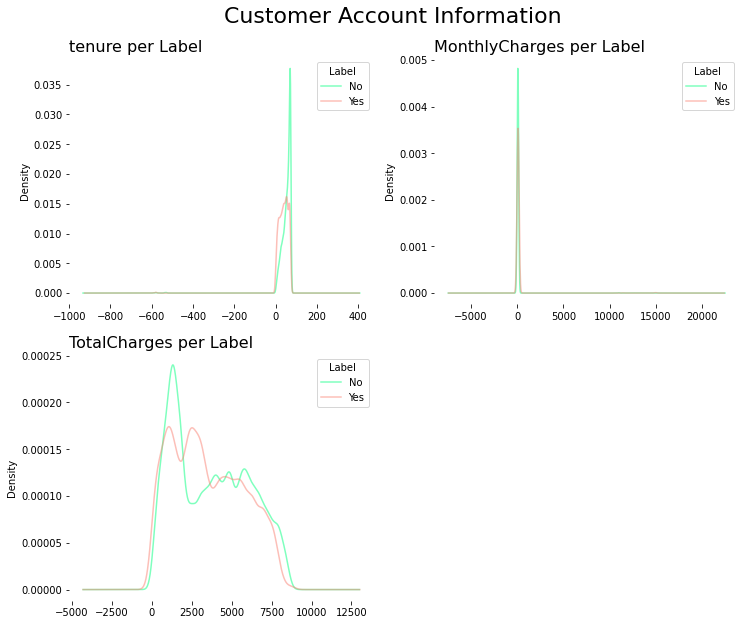

In [18]:
account_columns_numeric = ['tenure', 'MonthlyCharges', 'TotalCharges']
density_plots(df_pd, account_columns_numeric, 'Customer Account Information')

In [39]:
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import udf
from pyspark.sql.types import DoubleType

# UDF for converting column type from vector to double type
unlist = udf(lambda x: round(float(list(x)[0]),3), DoubleType())

# Iterating over columns to be scaled
for i in account_columns_numeric:
    # VectorAssembler Transformation - Converting column to vector type
    assembler = VectorAssembler(inputCols=[i],outputCol=i+"_Vect")

    # MinMaxScaler Transformation
    scaler = MinMaxScaler(inputCol=i+"_Vect", outputCol=i+"_index")

    # Pipeline of VectorAssembler and MinMaxScaler
    pipeline = Pipeline(stages=[assembler, scaler])

    # Fitting pipeline on dataframe
    df = pipeline.fit(df).transform(df).withColumn(i+"_index", unlist(i+"_index")).drop(i+"_Vect")

print("After Scaling :")
df.show(5)

After Scaling :
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------------+----------------+--------------------+--------------+------------+-----+------------+-------------+----------------+------------------+-------------------+---------------------+--------------------+------------------+----------------------+-----------------+-----------------+---------------------+--------------+----------------------+-------------------+-----------+------------+--------------------+------------------+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|      Contract|PaperlessBilling|       PaymentMethod|MonthlyCharges|TotalCharges|Label|gender_index|Partner_index|Dependents_index|PhoneService_index|MultipleLines_index|Int

In [40]:
features_col = ["tenure_index","MonthlyCharges_index","TotalCharges_index","SeniorCitizen","gender_index","Partner_index","Dependents_index","PhoneService_index","MultipleLines_index","InternetService_index","OnlineSecurity_index","OnlineBackup_index","DeviceProtection_index","TechSupport_index","StreamingTV_index","StreamingMovies_index","Contract_index","PaperlessBilling_index","PaymentMethod_index"]

i = j = 0
corr_matrix = [[0 for x in range(len(features_col))] for y in range(len(features_col))] 

for i in range(len(features_col)):
  col1 = features_col[i]
  for j in range(len(features_col)):
    col2 = features_col[j]
    corr_matrix[i][j] = df.stat.corr(col1,col2)
  
  print("correlation of Label and " + col1 + " : " + str(df.stat.corr(col1,'Label_index')))



correlation of Label and tenure_index : -0.12701212090969635
correlation of Label and MonthlyCharges_index : 0.007891794745763786
correlation of Label and TotalCharges_index : -0.03628589009108483
correlation of Label and SeniorCitizen : 0.1485679240172831
correlation of Label and gender_index : -0.016326515705542194
correlation of Label and Partner_index : 0.08204854679463729
correlation of Label and Dependents_index : -0.12269058784498946
correlation of Label and PhoneService_index : -0.021268995159031242
correlation of Label and MultipleLines_index : -0.07725986644163231
correlation of Label and InternetService_index : -0.27517341751687435
correlation of Label and OnlineSecurity_index : -0.017938966822475012
correlation of Label and OnlineBackup_index : -0.09086799267118002
correlation of Label and DeviceProtection_index : -0.08858004038681029
correlation of Label and TechSupport_index : -0.021242250645445288
correlation of Label and StreamingTV_index : -0.16797123752486928
correlat

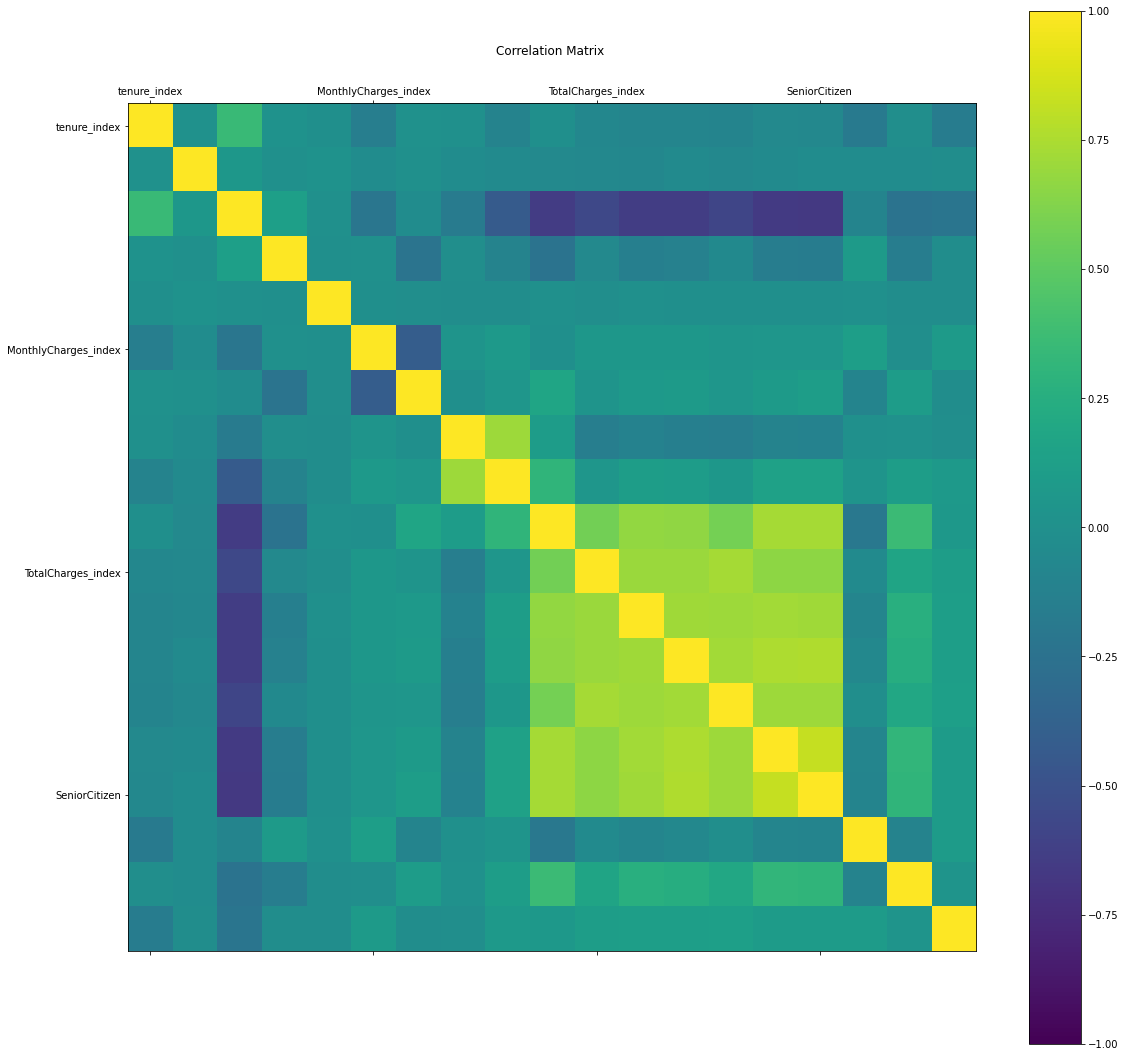

In [41]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(len(features_col),len(features_col)))
ax=fig.add_subplot(111)
ax.set_title("Correlation Matrix ")

ax.set_xticklabels(['']+features_col)
ax.set_yticklabels(['']+features_col)

cax=ax.matshow(corr_matrix,vmax=1,vmin=-1)
fig.colorbar(cax)
plt.show()

In [42]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=features_col,outputCol="features")
df_2 = assembler.transform(df)


In [43]:
df_2.select("features").show(5)

+--------------------+
|            features|
+--------------------+
|(19,[0,1,2,3,10,1...|
|(19,[0,1,2,10,11,...|
|(19,[0,1,2,3,8,9,...|
|(19,[0,1,2,8,9,10...|
|(19,[0,1,2,3,6,10...|
+--------------------+
only showing top 5 rows



In [44]:
train, test = df_2.randomSplit([0.7,0.3])
print("Train Count : " + str(train.count()))
print("Test Count : " + str(test.count()))

Train Count : 161071
Test Count : 68919


In [45]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol = "features", labelCol="Label_index", maxIter=10)
lrModel = lr.fit(train)
predictions = lrModel.transform(test)
predictions.select("Label_index","features", "rawPrediction", "probability", "prediction").show()

+-----------+--------------------+--------------------+--------------------+----------+
|Label_index|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+----------+
|        0.0|(19,[0,1,2,4,5,7,...|[1.72913401538767...|[0.56686792476285...|       0.0|
|        0.0|(19,[0,1,2,4,5,9,...|[3.33135509095284...|[0.97075071628196...|       0.0|
|        0.0|(19,[0,1,2,4,5,8,...|[2.37526667257852...|[0.77169034846469...|       0.0|
|        0.0|(19,[0,1,2,4,5,10...|[2.09056514690801...|[0.63569485666045...|       0.0|
|        0.0|(19,[0,1,2,4,11,1...|[1.80331821670863...|[0.53113213852969...|       0.0|
|        0.0|(19,[0,2,4,8,10,1...|[2.16318700525856...|[0.75593968237425...|       0.0|
|        1.0|(19,[0,1,2,4,7,8,...|[2.27242961063025...|[0.76294116746864...|       0.0|
|        0.0|(19,[0,2,4,8,9,11...|[3.78668995294384...|[0.99052274385841...|       0.0|
|        1.0|(19,[0,1,2,4,6,12..

In [46]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Label_index")
print("evaluation : ", evaluator.evaluate(predictions))


evaluation :  0.8412785027801682


In [47]:
accuracy = predictions.filter(predictions.Label_index == predictions.prediction).count() / float(predictions.count())
print("Accuracy : ",accuracy)

Accuracy :  0.8648268256939305


In [50]:
tp = predictions.filter((predictions.Label_index == 1) & (predictions.prediction == 1)).count()
fp = predictions.filter((predictions.Label_index == 0) & (predictions.prediction == 1)).count()
precision = tp / (tp+fp)
print("Precision : ",precision)

Precision :  0.6027088036117382


Must Be Comment

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import StringType, IntegerType, DoubleType
from pyspark.sql.functions import udf
import hashlib
from pyspark.sql.functions import col,isnan, when, count

def NA_Imputer(text):
  if text:
    return text
  else:
    return "Not Defined"
ol_val = udf(NA_Imputer, StringType())


def SeniorCitizen_Imputer(val):
  if val is not None and val > 0:
    return 1
  return 0
ol_val2 = udf(SeniorCitizen_Imputer, IntegerType())


df = df.withColumn("gender", ol_val(df.gender))\
        .withColumn("SeniorCitizen", ol_val2(df.SeniorCitizen))\
        .withColumn("Partner", ol_val(df.Partner))\
        .withColumn("Dependents", ol_val(df.Dependents))\
        .withColumn("PhoneService", ol_val(df.PhoneService))\
        .withColumn("MultipleLines", ol_val(df.MultipleLines))\
        .withColumn("InternetService", ol_val(df.InternetService))\
        .withColumn("OnlineSecurity", ol_val(df.OnlineSecurity))\
        .withColumn("OnlineBackup", ol_val(df.OnlineBackup))\
        .withColumn("DeviceProtection", ol_val(df.DeviceProtection))\
        .withColumn("TechSupport", ol_val(df.TechSupport))\
        .withColumn("StreamingTV", ol_val(df.StreamingTV))\
        .withColumn("StreamingMovies", ol_val(df.StreamingMovies))\
        .withColumn("Contract", ol_val(df.Contract))\
        .withColumn("PaperlessBilling", ol_val(df.PaperlessBilling))\
        .withColumn("PaymentMethod", ol_val(df.PaymentMethod))\
        .withColumn("Label", ol_val(df.Label))

df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()